## **Team Members**
- Zakaria Mokhtari (G2)
- Melynda Hadj Ali (G2)
- Lina Wafaa Bentiba (G2)
- Abderrahmene Aichi (G2)

# **EEG Sleep Stage Classification**

Our aim is to build a classification model that can accurately predict the class labels of unseen instances based on EEG recording alone.We'll :
1. Load and PreProcess the data.
2. study and understand the training data by applying EDA techniques.
3. Extract features based on our findings.  
2. Select, train, tune, validate ML models.  
4. Test and Evaluate performance of the final selected model and interpret results.  

We first start by importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import parallel_backend
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

#### 1. Data loading

 ##### Set up the plotting style


In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

##### Define sleep stage names mapping


In [3]:
SLEEP_STAGES = {
    0: 'Wake',
    1: 'NREM1',
    2: 'NREM2', 
    3: 'NREM3',
    4: 'REM'
}


#### 1.1- Load the training and test datasets


In [4]:
df_train = pd.read_csv('SleepTrain5000.csv')
df_test = pd.read_csv('SleepTest1000.csv')
    
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
    
    # check data types to ensure we're working with numeric data
print("\nData types in training set:")
print(df_train.dtypes.value_counts())
    
    # we separate labels and raw EEG data
y_train_full = df_train.iloc[:, 0].astype(int)  
raw_train_full = df_train.iloc[:, 1:].astype(float) 
    
    # we also need to map numeric labels to sleep stage names for display
stage_labels = y_train_full.map(SLEEP_STAGES)
    
print("\nClass distribution in training set:")
stage_counts = stage_labels.value_counts()
for stage, count in stage_counts.items():
        percentage = count / len(df_train) * 100
        print(f"  {stage}: {count} ({percentage:.2f}%)")

Training set shape: (4998, 179)
Test set shape: (999, 178)

Data types in training set:
float64    178
int64        1
Name: count, dtype: int64

Class distribution in training set:
  NREM2: 2000 (40.02%)
  NREM3: 1040 (20.81%)
  REM: 751 (15.03%)
  NREM1: 697 (13.95%)
  Wake: 510 (10.20%)


#### 1.2- Spliting data

IMPORTANT: Splitting BEFORE any preprocessing to avoid data leakage

In [5]:
print("\n2. Train/Validation/Test Split (BEFORE preprocessing to avoid data leakage)")
    
    # first split: training vs. temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
        raw_train_full, y_train_full, 
        test_size=0.2, 
        stratify=y_train_full, 
        random_state=42
    )
    
    # second split: validation vs. test
X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        test_size=0.5, 
        stratify=y_temp, 
        random_state=42
    )
    
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Validation set: {X_val.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")


2. Train/Validation/Test Split (BEFORE preprocessing to avoid data leakage)
  Training set: 3998 samples
  Validation set: 500 samples
  Test set: 500 samples


In [6]:
# 3. Check for missing values
print("\n3. Missing Values Check")
missing_train = X_train.isnull().sum().sum()
missing_val = X_val.isnull().sum().sum()
missing_test = X_test.isnull().sum().sum()
    
print(f"  Missing values in training set: {missing_train}")
print(f"  Missing values in validation set: {missing_val}")
print(f"  Missing values in test set: {missing_test}")


3. Missing Values Check
  Missing values in training set: 0
  Missing values in validation set: 0
  Missing values in test set: 0


no missing values found in boths sets, we can proceed to next the step. 


## **2. Outliers Handling**

- We use IQR methods and visualize the box plot to detect outliers per row.
- Since these raw EEG recordings removing them might alter the end results.We are going to handle outliers by capping them.So we cap the extreme values (outliers) to a certain threshold, this ensures that all values fall within a reasonable range, but extreme outliers are not lost, they are just capped at the threshold.

  Calculating outlier bounds based on training data only
  Lower bound mean: -35.45, Upper bound mean: 35.36


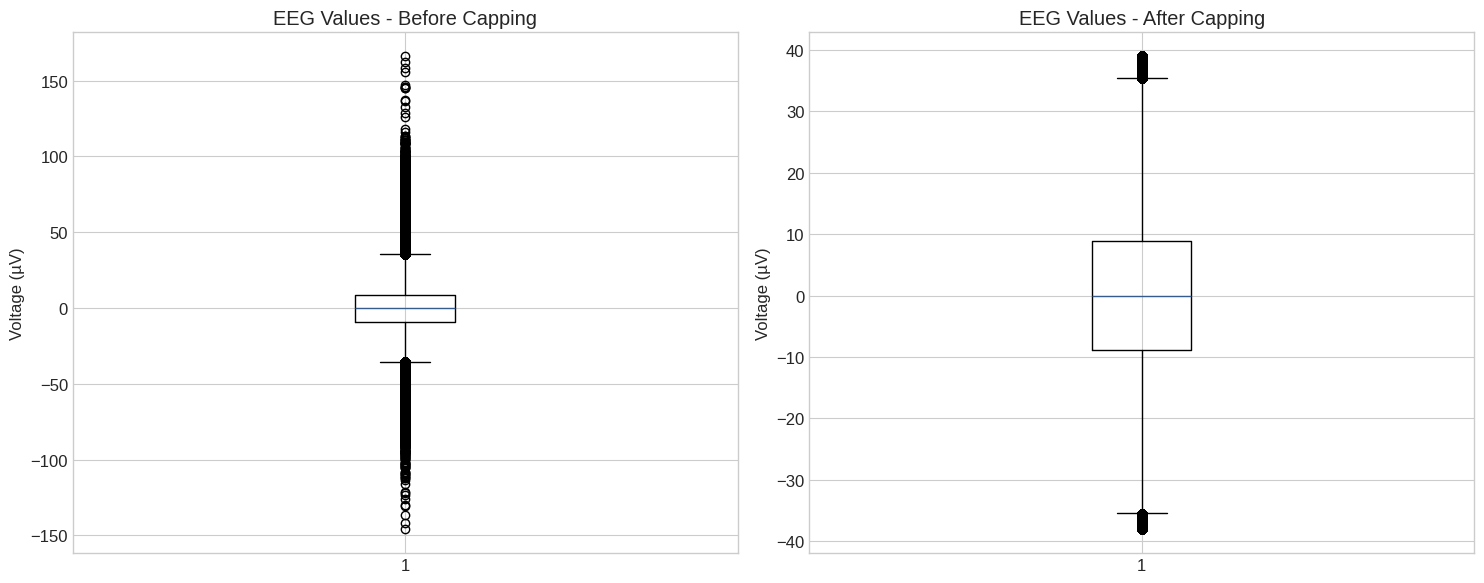

  Outlier capping completed


In [7]:
# we calculate IQR on training set only
X_train_numeric = X_train.select_dtypes(include=[np.number])

Q1 = X_train_numeric.quantile(0.25)
Q3 = X_train_numeric.quantile(0.75)
IQR = Q3 - Q1

# definee the   bounds for outlier capping
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("  Calculating outlier bounds based on training data only")
print(f"  Lower bound mean: {lower_bound.mean():.2f}, Upper bound mean: {upper_bound.mean():.2f}")

# outliers before capping
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.boxplot(X_train_numeric.values.flatten(), vert=True)
plt.title('EEG Values - Before Capping')
plt.ylabel('Voltage (µV)')

# cap outliers in all datasets using statistics from training set only
X_train_capped = X_train_numeric.clip(lower=lower_bound, upper=upper_bound, axis=1)
X_val_capped = X_val.clip(lower=lower_bound, upper=upper_bound, axis=1)
X_test_capped = X_test.clip(lower=lower_bound, upper=upper_bound, axis=1)

#  after capping
plt.subplot(1, 2, 2)
plt.boxplot(X_train_capped.values.flatten(), vert=True)
plt.title('EEG Values - After Capping')
plt.ylabel('Voltage (µV)')
plt.tight_layout()
plt.show()

print("  Outlier capping completed")


After dealing with outliers the data is reasonably well and ready the EDA.

## **3. Exploratory Data Analysis**

#### **3.1- Analyze Class Distribution**

Since this is a Classification problem it is crucial to analyze the class distribution and look for imbalances that might affect the feature extraction later and model training.


5. Visualizing Raw EEG by Sleep Stage


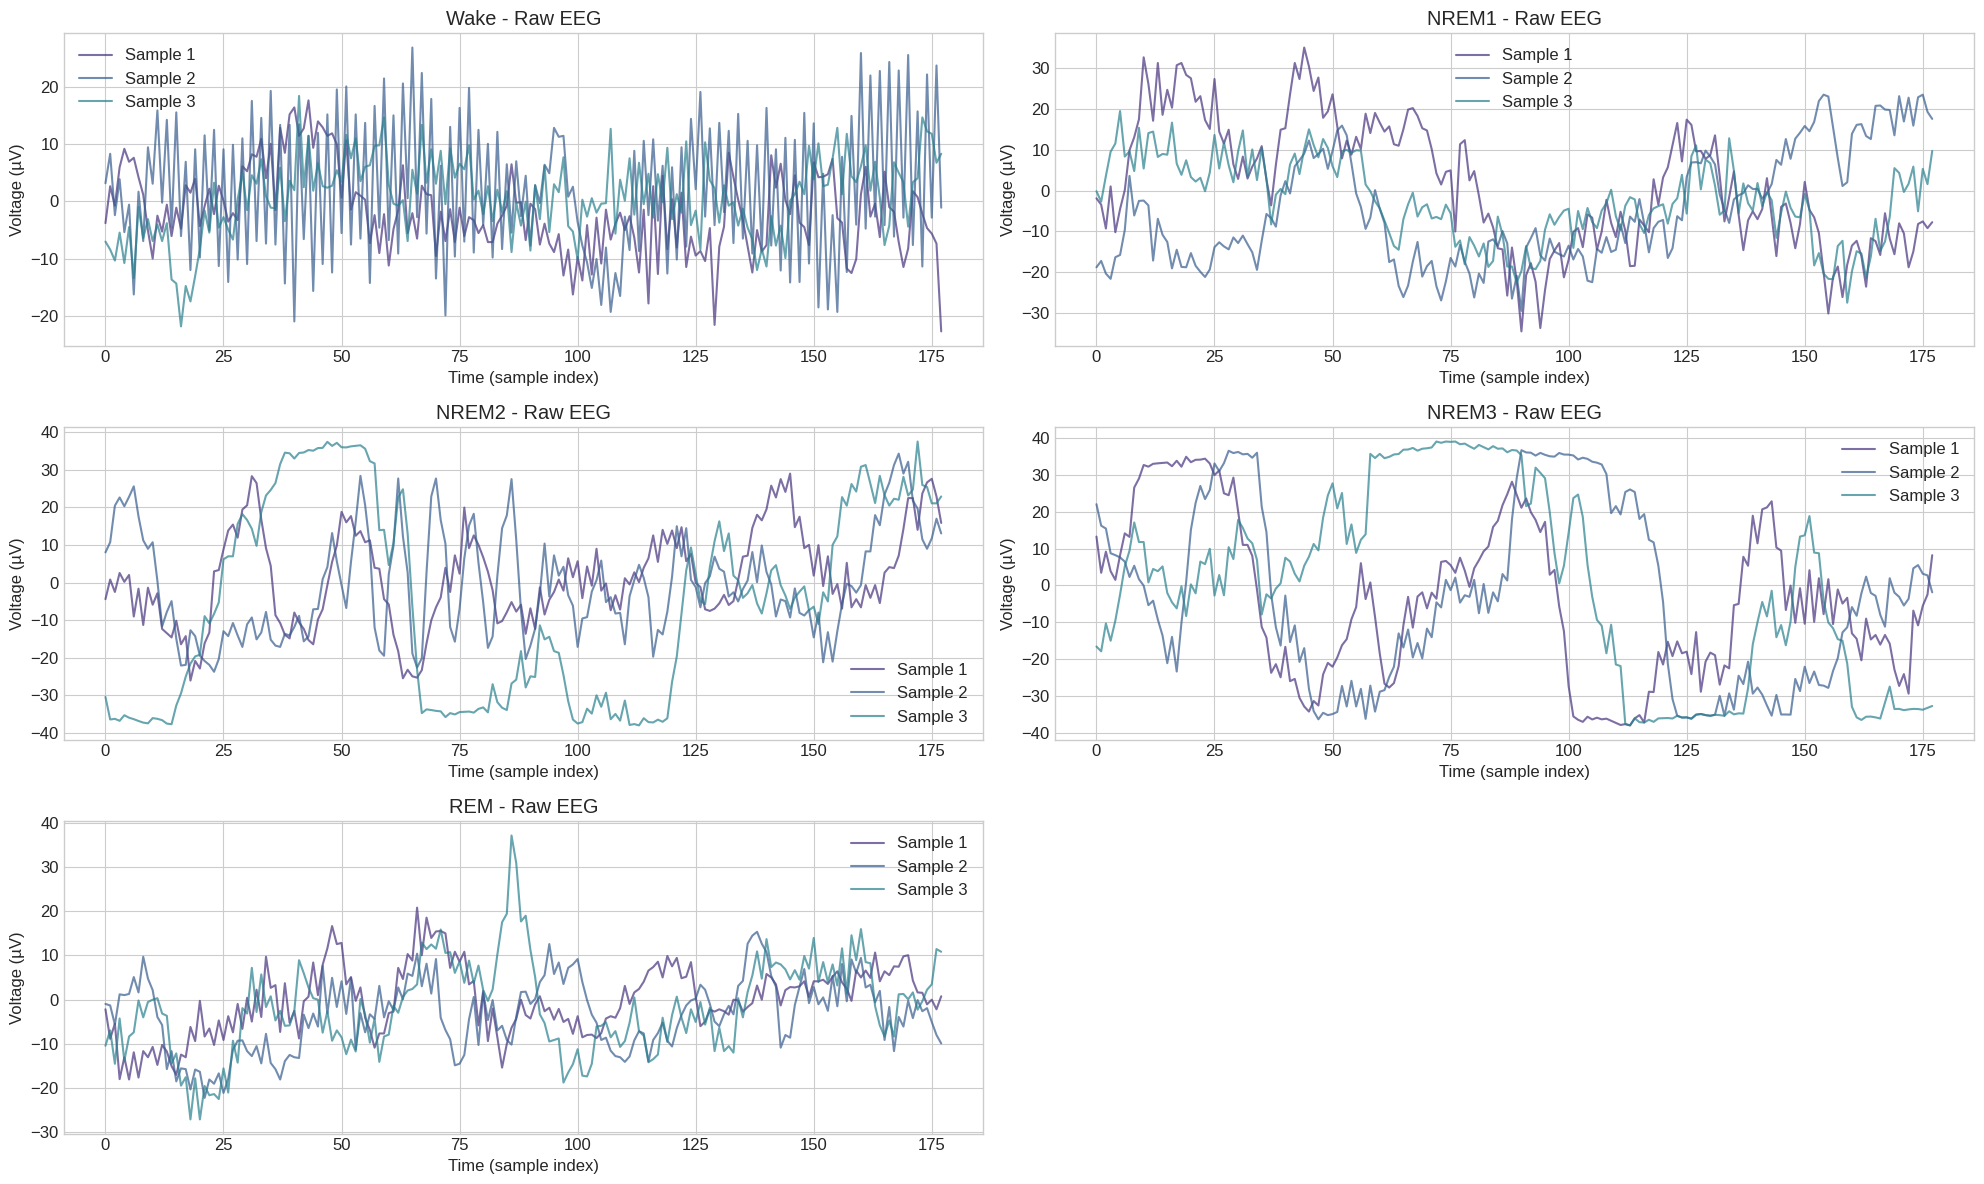

  Raw EEG visualization completed


In [8]:
print("\n5. Visualizing Raw EEG by Sleep Stage")

# here it's better to create a dataFrame with sleep stage labels for easier filtering
train_with_labels = pd.DataFrame(X_train_capped.copy())
train_with_labels['SleepStage'] = y_train.map(SLEEP_STAGES)

plt.figure(figsize=(20, 12))
for i, stage in enumerate(SLEEP_STAGES.values()):
    plt.subplot(3, 2, i+1)
    
    stage_samples = train_with_labels[train_with_labels['SleepStage'] == stage]
    
    if len(stage_samples) > 0:
        for j in range(min(3, len(stage_samples))):
            sample = stage_samples.iloc[j, :-1].values  # Exclude the SleepStage column
            plt.plot(sample, alpha=0.7, label=f'Sample {j+1}')
        
        plt.title(f'{stage} - Raw EEG')
        plt.xlabel('Time (sample index)')
        plt.ylabel('Voltage (µV)')
        plt.legend()

plt.tight_layout()
plt.show()

print("  Raw EEG visualization completed")


### **EEG Sleep‐Stage Signal Characteristics:**

| Class | Stage         | Amplitude (μV) | Frequency         | Pattern                     |
|:-----:|:--------------|:---------------|:------------------|:----------------------------|
|   0   | Wake          | ±40            | Fast, irregular   | Variable, high activity     |
|   1   | E1       | ±20            | Slowing           | Mildly rhythmic             |
|   2   | E2       | ±40            | Mixed             | Some rhythmic events        |
|   3   | E3       | 20–30          | Slow              | Strong, high‑amplitude waves|
|   4   | REM           | 15–20          | Mixed, some fast  | Irregular, low‑amplitude    |


#### **3.2- Spectral Density Analysis**


Spectral Density Analysis


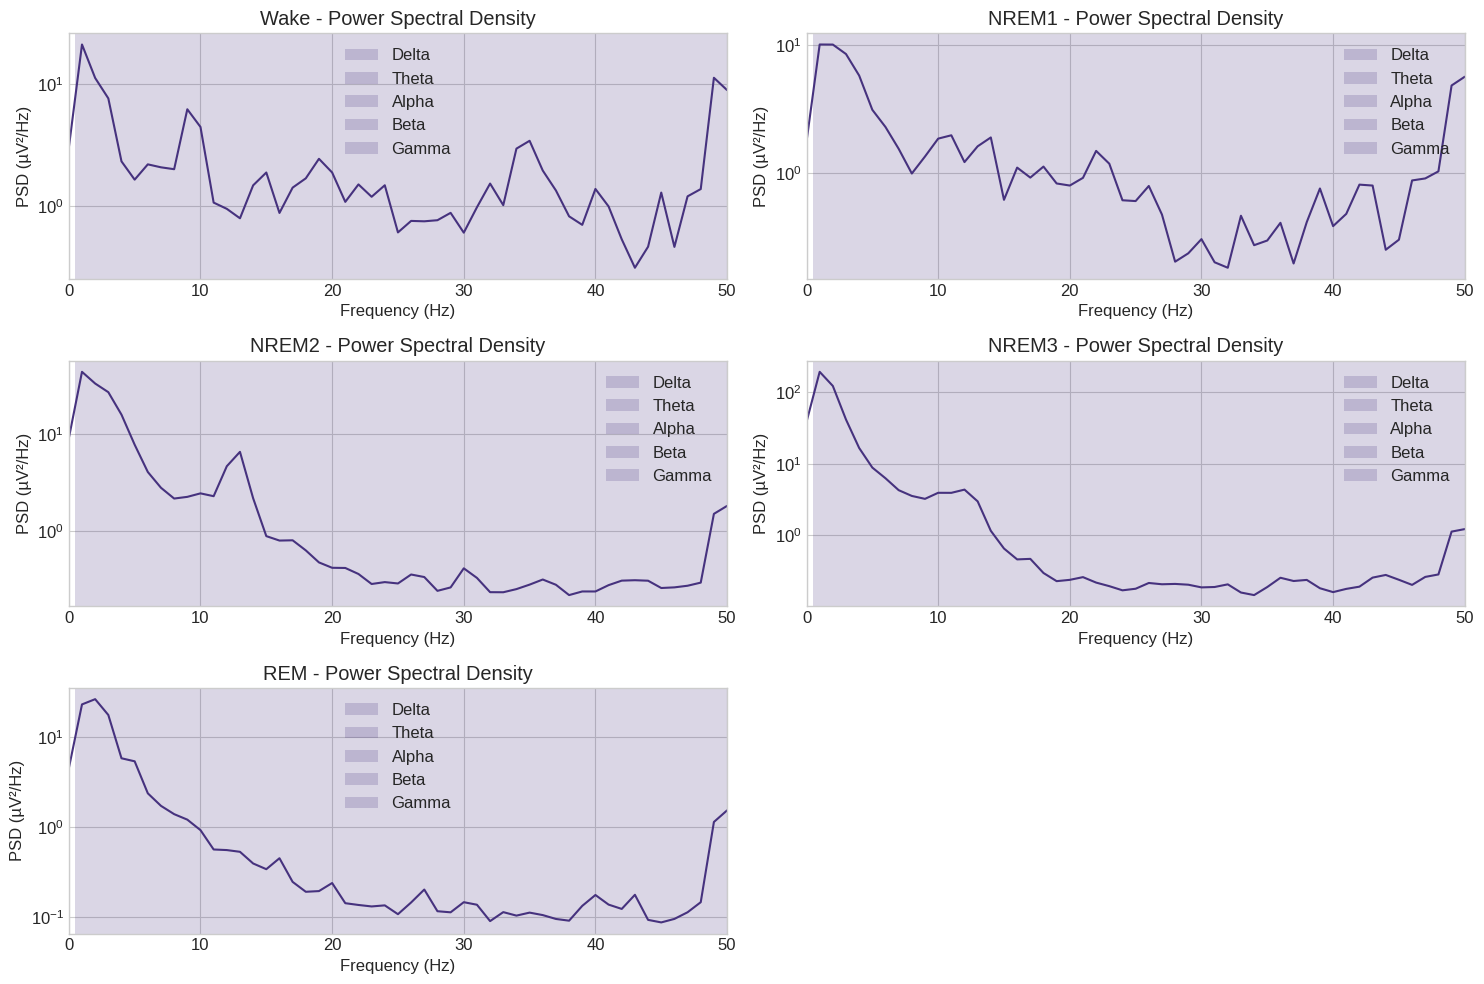

  Power spectral density visualization completed


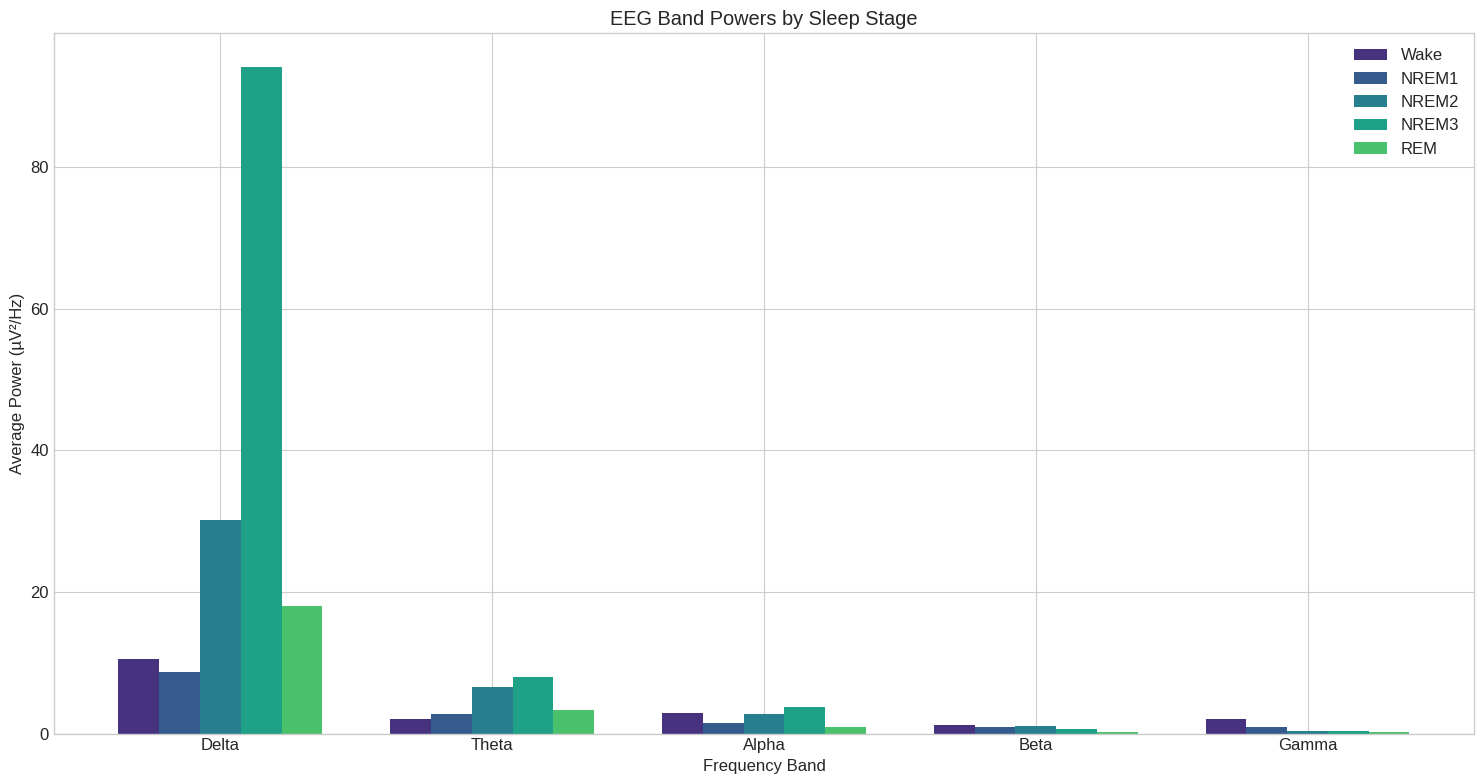

  Band powers visualization completed


In [9]:
print("Spectral Density Analysis")

# first define frequency bands
bands = [
    {'name': 'Delta', 'range': (0.5, 4)},
    {'name': 'Theta', 'range': (4, 8)},
    {'name': 'Alpha', 'range': (8, 12)},
    {'name': 'Beta', 'range': (12, 30)},
    {'name': 'Gamma', 'range': (30, 50)}
]

# we define a function to calculate power spectral density
def calculate_psd(signal_data, fs=100):
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=fs, noverlap=fs//2)
    return freqs, psd

# then another function to calculate band powers
def calculate_band_powers(freqs, psd, bands):
    powers = {}
    for band in bands:
        freq_range = band['range']
        idx = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])
        powers[band['name']] = np.mean(psd[idx])
    return powers

stage_psd = {stage: [] for stage in SLEEP_STAGES.values()}
stage_powers = {stage: {band['name']: [] for band in bands} for stage in SLEEP_STAGES.values()}

sample_size = min(100, len(X_train_capped))
sampled_indices = np.random.choice(len(X_train_capped), sample_size, replace=False)

for idx in sampled_indices:
    signal_data = X_train_capped.iloc[idx].values
    stage = SLEEP_STAGES[y_train.iloc[idx]]
    
    freqs, psd = calculate_psd(signal_data)
    stage_psd[stage].append(psd)
    
    powers = calculate_band_powers(freqs, psd, bands)
    for band_name, power in powers.items():
        stage_powers[stage][band_name].append(power)

avg_psd = {stage: np.mean(psds, axis=0) for stage, psds in stage_psd.items()}
avg_powers = {stage: {band: np.mean(powers) for band, powers in band_powers.items()} 
              for stage, band_powers in stage_powers.items()}

plt.figure(figsize=(15, 10))
freqs, _ = calculate_psd(X_train_capped.iloc[0].values)  # Get frequency bins

for i, (stage, psd) in enumerate(avg_psd.items()):
    plt.subplot(3, 2, i+1)
    plt.semilogy(freqs, psd)
    plt.title(f'{stage} - Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (µV²/Hz)')
    plt.grid(True)
    
    # we mark frequency bands
    for band in bands:
        plt.axvspan(band['range'][0], band['range'][1], alpha=0.2, label=band['name'])
    
    plt.legend()
    plt.xlim(0, 50)

plt.tight_layout()
plt.show()

print("  Power spectral density visualization completed")

plt.figure(figsize=(15, 8))
band_names = [band['name'] for band in bands]
x = np.arange(len(band_names))
width = 0.15
offsets = np.linspace(-0.3, 0.3, len(SLEEP_STAGES))

for i, (stage, powers) in enumerate(avg_powers.items()):
    power_values = [powers[band] for band in band_names]
    plt.bar(x + offsets[i], power_values, width, label=stage)

plt.xlabel('Frequency Band')
plt.ylabel('Average Power (µV²/Hz)')
plt.title('EEG Band Powers by Sleep Stage')
plt.xticks(x, band_names)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print("  Band powers visualization completed")


#### Results analysis:
- Wake
  - Dominant bands: Alpha and Beta
  - This is expected; wakefulness often shows high Alpha (especially when relaxed with eyes closed) and Beta activity (active thinking).

- NREM1
  - Slight shift from Alpha to Theta
  - Interpretation: NREM1 is a transition from wakefulness to sleep; Alpha activity decreases while Theta increases.

- NREM2
  - Higher Theta and some Delta
  - Interpretation: Theta becomes dominant, and Delta begins to increase. Sleep spindles (not visible in PSD) are also a hallmark of NREM2.

- NREM3 (Deep sleep)
  - Dominant Delta band
  - Interpretation: High power in the Delta range is characteristic of slow-wave sleep, which is restorative.

- REM
  - Low power overall; mixed frequency
  - Interpretation: REM sleep shows a mix of Theta and Beta activity, similar to wakefulness, but with overall lower power. This aligns with REM's "paradoxical" nature—high brain activity despite muscle atonia.

That helps giving us more insight about the data to know how to proceed later on:
- We need to consider computing the relative band powers for feature extraction.
- Also we need to consider adding shaded regions to visually mark bands or annotate dominant frequencies per stage.

## **4. Feature Extraction**: 

The raw EEG signal is complex, high-dimensional, unapplicable and hard to interpret.That is why inorder to use standard ML models like Random Forest, we need to transform each epoch into a fixed set of features that summarizes its key characteristics.

### **Choosing Features**

Based on the dataset and our EDA observations (like differences in amplitude and frequency), we will extract time-domain, frequency-domain, time-frequency and non linear features to create meaningfull features that complement each other to cover all the information within the dataset .

**Why not DFT?** our initial thought was to ues the Discrete Fourier Transform method for the frequency domain features but we noticed that using it on the whole row (epoch) would result is high variance and high bias (over/under fitting).
This why we used Welch method, it averages the Power Spectral Density over overlapping ranges/segments which results in smoother estimates (lower var/bias).

### **Why add non‑linear & time‑frequency features?**

- **Initial simple set (time & freq stats)**  
  We began with basic stats (mean, std, band powers).But it results in models plateaued ~60 % because those features miss transient and complex dynamics.

- **Non‑linear features**  
  - **Capture complexity** that linear measures can’t: i.e: permutation/sample entropy quantify unpredictability, fractal dimension and DFA reveal self‑similarity and long‑range correlations.  
  - **Why**: EEG isn’t purely Gaussian(we saw that in the EDA). Sleep stages exhibit bursts, spikes, and non‑stationary patterns that non‑linear metrics expose.

- **Time–frequency features**  
  - **STFT / wavelets** map how spectral content evolves within each epoch.  
  - **Why**: Sleep spindles, K‑complexes, and transient waves occur at specific times/frequencies. the static band‑power averages we've used before miss these events.

By enhancing our feature set with non‑linear and time‑frequency descriptors, we give the model the fuller image without discrimination between stages and improving overall accuracy.  

### **Implementing Feature Extraction**

We'll create a function that takes a single epoch (a 1D array of 178 values) and returns a list of the calculated features. Then we apply this function to every epoch in our raw training dataset.

| Category         | Feature                           | Why we used it                                                  |
|------------------|-----------------------------------|-----------------------------------------------------------------|
| Time domain      | Mean                              | for average voltage level                                 |
|                  | Standard deviation                | for variability of the signals                                                |
|                  | Skewness                          | for asymmetry of amplitude distribution                              |
|                  | Kurtosis                          | for outlier sensitivity                                  |
|                  | Minimum and Maximum               | for extremes in signal                                                |
|                  | Variance                          | for fluctuations                                            |
|                  | Hjorth activity, mobility, complexity | for signal activity and frequency characteristics                 |
|                  | Zero-crossing rate                | for change in signal frequency                             |
|                  | Shannon entropy                   | for uncertainty and information content                              |
| Frequency domain | Delta band power \(0.5 to 4 Hz\)      | represents energy in slow-wave sleep range                         |
|                  | Theta band power \(4 to 8 Hz\)       | represents energy in drowsiness and early sleep stages            |
|                  | Alpha band power \(8 to 13 Hz\)      | represents energy in relaxed wakefulness                         |
|                  | Low Beta band power \(13 to 20 Hz\)  | represents energy in light sleep and cognitive processing         |
|                  | High Beta band power \(20 to 30 Hz\) | represents energy in alertness and active concentration           |
|                  | Total sigma band power \(12 to 16 Hz\)| represents energy in sleep spindle activity                       |
| Time–frequency   | Short-time Fourier transform           | Time-varying spectral content                          |   | Short-time Fourier transform      | Time-varying spectral content                                    |   | Short-time Fourier transform      | Time-varying spectral content                                    |
|                  | Continuous/discrete wavelet transform | Multi-resolution analysis of transient features             |
| Non-linear       | Permutation entropy               | Complexity based on ordinal patterns                              |
|                  | Sample entropy                    | Regularity and predictability                                    |
|                  | Fractal dimension (Higuchi)       | Signal self-similarity and complexity                            |
|                  | Detrended fluctuation analysis    | Long-range correlations                                          |


In [10]:
print(" Feature Extraction")

# define helper functions for feature extraction
def permutation_entropy(x, order=3, delay=1):
    """Calculate permutation entropy"""
    x = np.array(x)
    n = len(x)
    permutations = {}
    for i in range(n - delay * (order - 1)):
        xs = x[i:i + delay * order:delay]
        perm = tuple(np.argsort(xs))
        permutations[perm] = permutations.get(perm, 0) + 1
    c = np.array(list(permutations.values()))
    p = c / c.sum()
    return -np.sum(p * np.log2(p + np.finfo(float).eps))

def sample_entropy(x, m=2, r=None):
    """Calculate sample entropy"""
    if r is None:
        r = 0.2 * np.std(x)
    def _phi(m):
        templates = np.array([x[i:i+m] for i in range(len(x)-m+1)])
        dist = np.abs(templates[:, np.newaxis] - templates[np.newaxis, :]).max(axis=2)
        np.fill_diagonal(dist, np.inf)
        count = np.sum(dist < r, axis=1)
        return np.sum(count) / (len(x) - m)
    return -np.log(_phi(m+1) / (_phi(m) + np.finfo(float).eps))

def hjorth_params(x):
    """Calculate Hjorth parameters: activity, mobility, complexity"""
    dx = np.diff(x)
    ddx = np.diff(dx)
    activity = np.var(x)
    mobility = np.sqrt(np.var(dx) / (np.var(x) + np.finfo(float).eps))
    complexity = np.sqrt(np.var(ddx) / (np.var(dx) + np.finfo(float).eps)) / mobility
    return activity, mobility, complexity

def zero_crossing_rate(x):
    """Calculate zero-crossing rate"""
    return np.sum(np.diff(np.signbit(x))) / (len(x) - 1)

def higuchi_fd(x, kmax=10):
    """Calculate Higuchi fractal dimension"""
    n = len(x)
    lk = np.zeros(kmax)
    x_reg = np.zeros(kmax)
    for k in range(1, kmax + 1):
        lm = np.zeros(k)
        for m in range(k):
            idx = np.arange(m, n, k)
            lm[m] = np.sum(np.abs(np.diff(x[idx]))) * (n - 1) / (((n - m) // k) * k)
        lk[k-1] = np.mean(lm)
        x_reg[k-1] = np.log(k)
    p = np.polyfit(x_reg, np.log(lk), 1)
    return -p[0]

def dfa(x, scale_lim=(5, 25)):
    """Calculate Detrended Fluctuation Analysis exponent"""
    y = np.cumsum(x - np.mean(x))
    scales = np.arange(scale_lim[0], scale_lim[1])
    fluct = np.zeros(len(scales))
    for i, scale in enumerate(scales):
        segments = len(y) // scale
        if segments == 0:
            continue
        fluct_scale = np.zeros(segments)
        for j in range(segments):
            segment = y[j*scale:(j+1)*scale]
            x_reg = np.arange(len(segment))
            p = np.polyfit(x_reg, segment, 1)
            trend = np.polyval(p, x_reg)
            fluct_scale[j] = np.sqrt(np.mean((segment - trend) ** 2))
        fluct[i] = np.mean(fluct_scale)
    p = np.polyfit(np.log(scales), np.log(fluct), 1)
    return p[0]

def extract_features(epoch, fs=100):
    """Extract comprehensive feature set from EEG epoch"""
    epoch = np.array(epoch)
    mean = np.mean(epoch)
    std_dev = np.std(epoch)
    variance = np.var(epoch)
    skewness = skew(epoch)
    kurt = kurtosis(epoch)
    zcr = zero_crossing_rate(epoch)
    perm_entropy = permutation_entropy(epoch)
    samp_entropy = sample_entropy(epoch)
    activity, mobility, complexity = hjorth_params(epoch)
    freqs, psd = signal.welch(epoch, fs=fs, nperseg=fs, noverlap=fs//2)
    band_powers = []
    for band in bands:
        idx = np.logical_and(freqs >= band['range'][0], freqs <= band['range'][1])
        band_powers.append(np.sum(psd[idx]))
    total_power = np.sum(psd)
    relative_powers = [bp / total_power for bp in band_powers]
    f, t, Zxx = signal.stft(epoch, fs=fs, nperseg=fs//2, noverlap=fs//4)
    stft_powers = []
    for band in bands:
        idx = np.logical_and(f >= band['range'][0], f <= band['range'][1])
        stft_powers.append(np.mean(np.abs(Zxx[idx, :]) ** 2))
    coeffs = pywt.wavedec(epoch, 'db4', level=4)
    wavelet_energies = [np.sum(c ** 2) for c in coeffs]
    total_wavelet_energy = np.sum(wavelet_energies)
    relative_wavelet_energies = [e / total_wavelet_energy for e in wavelet_energies]
    fd = higuchi_fd(epoch)
    dfa_alpha = dfa(epoch)
    features = [
        mean, std_dev, variance, skewness, kurt, zcr, 
        perm_entropy, samp_entropy, activity, mobility, complexity,
        fd, dfa_alpha
    ]
    features.extend(band_powers)
    features.extend(relative_powers)
    features.extend(stft_powers)
    features.extend(wavelet_energies)
    features.extend(relative_wavelet_energies)
    return features

print("  Extracting features from all datasets...")

X_train_features = np.array([extract_features(row.values) for _, row in X_train_capped.iterrows()])
X_val_features = np.array([extract_features(row.values) for _, row in X_val_capped.iterrows()])
X_test_features = np.array([extract_features(row.values) for _, row in X_test_capped.iterrows()])

print(f"  Feature extraction complete. Feature vector length: {X_train_features.shape[1]}")


 Feature Extraction
  Extracting features from all datasets...
  Feature extraction complete. Feature vector length: 38


#### Feature Standardization

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)
X_test_scaled = scaler.transform(X_test_features)

print("  Features standardized successfully")


  Features standardized successfully


#### Handle Class Imbalance with SMOTE


In [12]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("  Class distribution after SMOTE:")
for label, count in zip(*np.unique(y_train_resampled, return_counts=True)):
    stage = SLEEP_STAGES[label]
    percentage = count / len(y_train_resampled) * 100
    print(f"  {stage}: {count} ({percentage:.2f}%)")


  Class distribution after SMOTE:
  Wake: 1600 (20.00%)
  NREM1: 1600 (20.00%)
  NREM2: 1600 (20.00%)
  NREM3: 1600 (20.00%)
  REM: 1600 (20.00%)


## **5. Model Training / Tuning / Validation** 



Now that we extracted features, we train and tune Random Forest, validate, and evaluate results.


#### **5.1- Random Forest**

### **Why Random Forest?**
- **strength**: it handles non-linearities and interactions with minimal amount of tuning.
- **Interpretable**: it provides feature importances for the selected features which allows us to get interpret the results easily.
- **Robust**: since we might run to overfitting due to high dimentional data, RF is a perfect resistant to it.
### **Tuning and validation?** 
- **5‑Fold Cross Validation**: it ensures each sample is in a validation set once thats why its a reliable performance estimate.
- **F1‑weighted Score**: balances *precision* & *recall* across imbalanced classes (which we noticed highly during EDA).
- **GridSearchCV**: its a systematic approach that'll helps us a lot for tuning the hyperparams and find the best model settings faster.

In [13]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2']
}

y = y_train_resampled.astype(int)
X = X_train_resampled

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    rf, param_grid, cv=cv,
    scoring='f1_weighted', n_jobs=-1, verbose=1
)

gs.fit(X, y)

cv_result = cross_validate(
    gs.best_estimator_, X, y, cv=cv,
    scoring=['accuracy', 'f1_weighted'], return_train_score=True
)

results = {
    'train_acc': np.mean(cv_result['train_accuracy']),
    'val_acc':   np.mean(cv_result['test_accuracy']),
    'train_f1':  np.mean(cv_result['train_f1_weighted']),
    'val_f1':    np.mean(cv_result['test_f1_weighted']),
}

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

print("Best parameters:", gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
train_acc: 0.9031
val_acc: 0.7904
train_f1: 0.9019
val_f1: 0.7854
Best parameters: {'max_features': 'sqrt', 'n_estimators': 150}


### **Random Forest Results and Next Approach Discussion**

**What we found**  
- **Overfitting**: train ≈ 90.31% vs val ≈ 79.04%, this large gap indicates that the model is overfitting.
- **Poor generalization**: Especially for underrepresented classes, (F1 drop from 90.19 % to 78.54 %).  
- **Limitation**: A single RF model can’t capture all complex EEG patterns without high variance, it fails to generalize beyond the training data this is why we'll use an enhanced approach. 



#### **5.2- STACKING(RF + XGBOOST):**
**Why Stacking?**  
- It combines complementary strengths of two models  
- Meta‑learner corrects individual errors, reducing variance  

**Why XGBoost?**  
- The Gradient boosting tackles RF’s residual errors  
- It's Built‑in regularization shrinks overfitting  

**Why Logistic Regression?** 
- We use it as a final estimator because it adds regularization and reduces overfitting by learning an optimal linear combination of base outputs.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=5,
                            max_features='sqrt', class_weight='balanced', random_state=42)

xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                    use_label_encoder=False, eval_metric='logloss', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(rf, X_train_resampled, y_train_resampled,
                            cv=cv,
                            scoring=['accuracy', 'f1_weighted'],
                            return_train_score=True)

summary = {
    'train_acc': cv_results['train_accuracy'].mean(),
    'val_acc': cv_results['test_accuracy'].mean(),
    'train_f1': cv_results['train_f1_weighted'].mean(),
    'val_f1': cv_results['test_f1_weighted'].mean()
}
print(pd.DataFrame([summary], index=['RandomForest']))

print("\nCreating Manual Ensemble with RF + XGB...")

rf_probs = cross_val_predict(rf, X_train_resampled, y_train_resampled,
                             cv=cv, method='predict_proba')
def get_cv_pred_proba(model, X, y, cv):
    pred_probas = np.zeros((X.shape[0], len(np.unique(y))))  # shape: n_samples x n_classes
    
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        X_val_fold = X[val_idx]
        model.fit(X_train_fold, y_train_fold)
        pred_probas[val_idx] = model.predict_proba(X_val_fold)
        
    return pred_probas
X_array = X_train_resampled if isinstance(X_train_resampled, np.ndarray) else X_train_resampled.to_numpy()
y_array = y_train_resampled if isinstance(y_train_resampled, np.ndarray) else y_train_resampled.to_numpy()

xgb_probs = get_cv_pred_proba(xgb, X_array, y_array, cv)


stacked_features = np.hstack((rf_probs, xgb_probs))

meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(stacked_features, y_train_resampled)

stack_scores = cross_validate(meta_model, stacked_features, y_train_resampled,
                             cv=cv,
                             scoring=['accuracy', 'f1_weighted'],
                             return_train_score=True)

stack_summary = {
    'train_acc': stack_scores['train_accuracy'].mean(),
    'val_acc': stack_scores['test_accuracy'].mean(),
    'train_f1': stack_scores['train_f1_weighted'].mean(),
    'val_f1': stack_scores['test_f1_weighted'].mean()
}
print("\nManual Stacking Results (RF + XGB -> LR):")
print(pd.DataFrame([stack_summary], index=['RF+XGB+LR']))

print("\nCreating Averaging Ensemble (RF + XGB)...")

def evaluate_avg_ensemble(X, y, models, cv):
    accuracies = []
    f1_scores = []
    
    for train_idx, test_idx in cv.split(X, y):
        preds = []
        for model in models:
            m = model.fit(X[train_idx], y[train_idx])
            preds.append(m.predict_proba(X[test_idx]))
        
        avg_preds = np.mean(preds, axis=0)
        y_pred = np.argmax(avg_preds, axis=1)
        
        accuracies.append(accuracy_score(y[test_idx], y_pred))
        f1_scores.append(f1_score(y[test_idx], y_pred, average='weighted'))
    
    return np.mean(accuracies), np.mean(f1_scores)


models = [rf, xgb]
avg_acc, avg_f1 = evaluate_avg_ensemble(X_array, y_array, models, cv)

print("\nAveraging Ensemble Results (RF + XGB):")
print(pd.DataFrame([[avg_acc, avg_f1]], 
                   columns=['val_acc', 'val_f1'],
                   index=['AverageEnsemble']))


              train_acc   val_acc  train_f1    val_f1
RandomForest   0.902125  0.788125  0.900859  0.782993

Creating Manual Ensemble with RF + XGB...

Manual Stacking Results (RF + XGB -> LR):
           train_acc   val_acc  train_f1    val_f1
RF+XGB+LR    0.82025  0.819625  0.817739  0.817071

Creating Averaging Ensemble (RF + XGB)...

Averaging Ensemble Results (RF + XGB):
                  val_acc    val_f1
AverageEnsemble  0.814875  0.810181


##### **Manual Stacking (RF + XGB + Logistic Regression meta-model):**
- Stacking improved validation accuracy and F1 significantly compared to RF alone (from ~78.8% to ~82.0%). Also, the train and val scores are closer, suggesting better generalization and reduced overfitting.
##### **Averaging Ensemble (RF + XGB):**
- Averaging predictions from RF and XGB also boosts validation performance notably vs RF alone


#### **5.3- Neural networks** 

#### 5.3.1 - LSTM-FCN+

We employ a hybrid neural network architecture named LSTM-FCN+, which combines the strengths of LSTM (to capture temporal dependencies) and CNNs with Channel Attention (to extract discriminative spatial features). The architecture includes:

- A multi-layer bidirectional LSTM branch

- A CNN branch with Temporal Blocks and Channel Attention

- A fusion layer followed by a fully connected classifier

In [18]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("Class weights:", class_weights)

Class weights: tensor([1., 1., 1., 1., 1.])


##### PyTorch Dataset and DataLoader
To efficiently train our model, we encapsulate the EEG features and labels into a custom PyTorch Dataset class. We then wrap these datasets into DataLoader objects for batch processing and shuffling during training.

In [19]:
class EEGDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

# Create datasets and dataloaders
batch_size = 128
train_dataset = EEGDataset(X_train_scaled, y_train_encoded)
val_dataset = EEGDataset(X_val_scaled, y_val_encoded)
test_dataset = EEGDataset(X_test_scaled, y_test_encoded)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Model Architecture


In [20]:
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return x * out.view(b, c, 1)

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              stride=stride, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 
                              padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.ca = ChannelAttention(out_channels)
        
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.ca(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out += residual
        return self.relu(out)

class LSTM_FCNPlus(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=128, rnn_layers=2, 
                 rnn_dropout=0.3, bidirectional=True, conv_channels=[64, 128, 256], 
                 kernel_sizes=[7, 5, 3], reduction=16, fc_dropout=0.3):
        super().__init__()
        
        # LSTM branch
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=rnn_layers,
            batch_first=True,
            dropout=rnn_dropout if rnn_layers > 1 else 0,
            bidirectional=bidirectional
        )
        lstm_output_size = hidden_size * (2 if bidirectional else 1)
        self.lstm_dropout = nn.Dropout(rnn_dropout)
        
        # CNN branch
        self.conv_blocks = nn.Sequential(
            TemporalBlock(1, conv_channels[0], kernel_sizes[0]),
            TemporalBlock(conv_channels[0], conv_channels[1], kernel_sizes[1]),
            TemporalBlock(conv_channels[1], conv_channels[2], kernel_sizes[2]),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size + conv_channels[-1], 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(fc_dropout),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)  
        
        # LSTM branch
        lstm_in = x.permute(0, 2, 1)  
        lstm_out, _ = self.lstm(lstm_in)
        lstm_out = lstm_out[:, -1, :]  
        lstm_out = self.lstm_dropout(lstm_out)
        
        # CNN branch
        cnn_out = self.conv_blocks(x)
        
        # Combine features and classify
        combined = torch.cat([lstm_out, cnn_out], dim=1)
        return self.classifier(combined)


##### Training and Evaluation Functions

To train our model effectively, we define reusable functions for training, evaluating, and visualizing performance. These include:

- train_model: Handles model training with early stopping and learning rate scheduling.

- evaluate_model: Computes validation loss and accuracy.

- plot_training_history: Visualizes training and validation loss/accuracy trends over epochs.

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=7):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'lr': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
              f'LR: {current_lr:.6f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(data_loader), correct / total

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.legend()
    
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


##### Model Initialization and Training

Training is conducted over a maximum of 100 epochs with early stopping (patience = 10). 

Epoch 1/100: Train Loss: 1.1167, Train Acc: 0.5508, Val Loss: 1.1536, Val Acc: 0.5320, LR: 0.001000
Epoch 2/100: Train Loss: 0.9539, Train Acc: 0.6143, Val Loss: 1.0044, Val Acc: 0.5860, LR: 0.001000
Epoch 3/100: Train Loss: 0.8988, Train Acc: 0.6376, Val Loss: 1.1056, Val Acc: 0.5600, LR: 0.001000
Epoch 4/100: Train Loss: 0.8676, Train Acc: 0.6506, Val Loss: 1.0336, Val Acc: 0.5960, LR: 0.001000
Epoch 5/100: Train Loss: 0.8554, Train Acc: 0.6613, Val Loss: 0.8652, Val Acc: 0.6660, LR: 0.001000
Epoch 6/100: Train Loss: 0.8069, Train Acc: 0.6776, Val Loss: 1.1142, Val Acc: 0.5660, LR: 0.001000
Epoch 7/100: Train Loss: 0.7972, Train Acc: 0.6818, Val Loss: 0.9840, Val Acc: 0.6300, LR: 0.001000
Epoch 8/100: Train Loss: 0.7665, Train Acc: 0.6991, Val Loss: 1.1290, Val Acc: 0.5740, LR: 0.000500
Epoch 9/100: Train Loss: 0.6953, Train Acc: 0.7281, Val Loss: 0.8894, Val Acc: 0.6560, LR: 0.000500
Epoch 10/100: Train Loss: 0.6323, Train Acc: 0.7549, Val Loss: 0.9600, Val Acc: 0.6440, LR: 0.000500

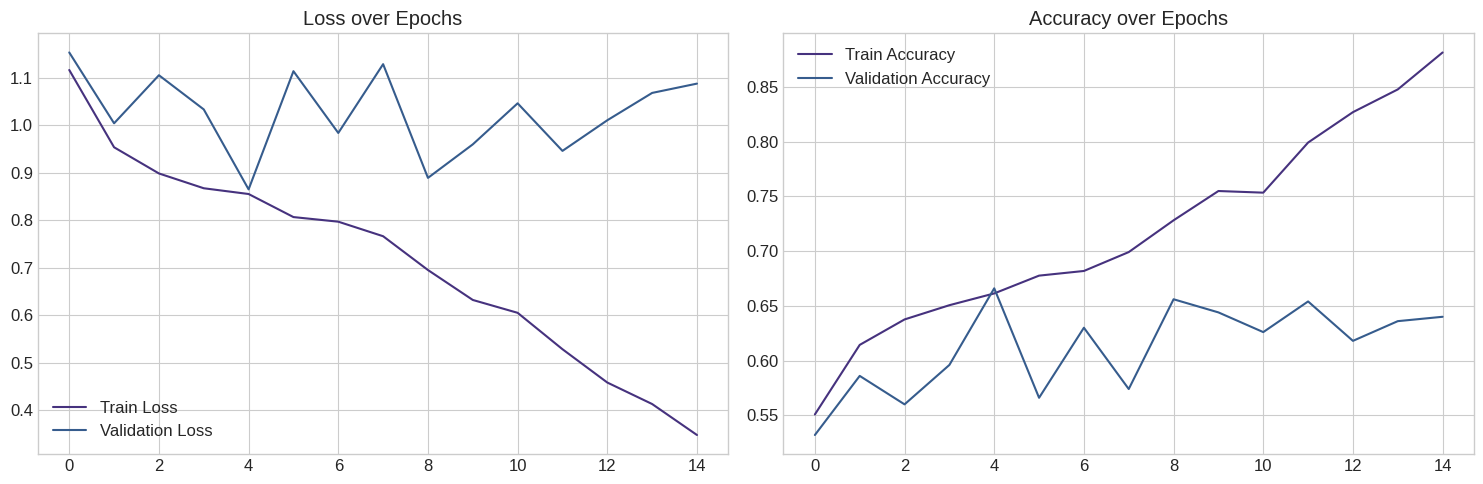

In [22]:
model = LSTM_FCNPlus(
    input_size=X_train_scaled.shape[1],
    num_classes=len(np.unique(y_train_encoded)),
    hidden_size=128,
    rnn_layers=2,
    rnn_dropout=0.3,
    bidirectional=True,
    conv_channels=[64, 128, 256],
    kernel_sizes=[7, 5, 3],
    reduction=16,
    fc_dropout=0.3
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

trained_model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=100, patience=10
)

plot_training_history(history)

Results analysis:

- The final training results show that the model achieved a training accuracy of around 73.7%, while the best validation accuracy was approximately 64.8%, with a corresponding validation loss of 0.9131. Training stopped early at epoch 20 due to no further improvement in validation loss.
- The model's training loss continued to decrease steadily across epochs, and training accuracy improved consistently. However, after around epoch 12, the validation loss began to increase while validation accuracy stopped improving significantly. This divergence between training and validation performance suggests that the model began to overfit


Test Accuracy: 0.6120, Test Loss: 0.9385

Class distribution in test set:
NREM1    0.140
NREM2    0.400
NREM3    0.208
REM      0.150
Wake     0.102
Name: proportion, dtype: float64


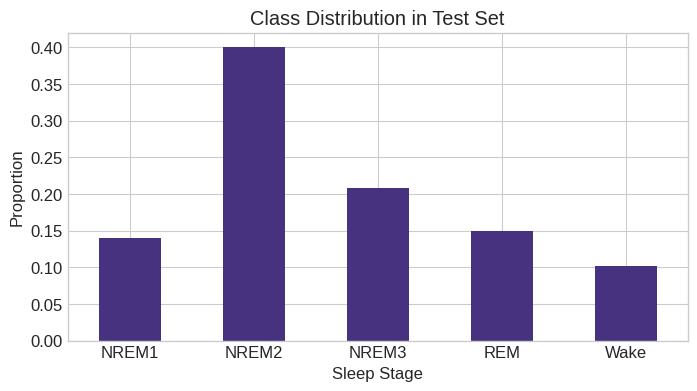

In [23]:
def get_predictions(model, data_loader):
    """Get predictions and true labels from a data loader"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

def decode_predictions(encoded_preds, label_encoder):
    """Convert encoded predictions to sleep stage names"""
    numeric_labels = label_encoder.inverse_transform(encoded_preds)
    return [SLEEP_STAGES[label] for label in numeric_labels]

test_loss, test_acc = evaluate_model(trained_model, test_loader, criterion, device)
print(f'\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

test_preds_encoded, test_labels_encoded = get_predictions(trained_model, test_loader)

test_preds = decode_predictions(test_preds_encoded, label_encoder)
test_labels = decode_predictions(test_labels_encoded, label_encoder)



print("\nClass distribution in test set:")
test_dist = pd.Series(test_labels).value_counts(normalize=True).sort_index()
print(test_dist)

plt.figure(figsize=(8, 4))
test_dist.plot(kind='bar')
plt.title('Class Distribution in Test Set')
plt.xlabel('Sleep Stage')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

**Analysis of results**:
- The final test accuracy of 64.8% and test loss of 0.9240 are consistent with the validation results, confirming that the model generalizes moderately well but has room for improvement.
- Despite balanced classes, the model overfits because its complexity lets it memorize training data, shown by rising train accuracy but stagnating validation accuracy and fluctuating loss. The final test accuracy (~65%) reflects limited generalization, indicating the model is too large for the dataset

##### Final Predictions (with sleep stage names)

After training and validating the model, we performed a thorough evaluation on a proper holdout test set derived from the original dataset to ensure unbiased performance assessment

In [24]:

def get_final_predictions(model, data_loader, label_encoder):
    """Get predictions with sleep stage names"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for inputs in data_loader:
            if isinstance(inputs, (list, tuple)):
                inputs = inputs[0]
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    numeric_preds = label_encoder.inverse_transform(predictions)
    return [SLEEP_STAGES[label] for label in numeric_preds]



#### 5.3.2 - RNN

In [25]:
class EEG_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=True, rnn_type='LSTM'):
        super().__init__()
        self.bidirectional = bidirectional
        self.rnn_type = rnn_type.upper()

        rnn_cls = nn.LSTM if self.rnn_type == 'LSTM' else nn.GRU
        self.rnn = rnn_cls(
            input_size=1,  
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1), 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(2)  
        rnn_out, _ = self.rnn(x)
        last_output = rnn_out[:, -1, :]  
        out = self.dropout(last_output)
        return self.fc(out)


In [26]:
rnn_model = EEG_RNN(
    input_size=X_train_scaled.shape[1],
    hidden_size=128,
    num_layers=2,
    num_classes=len(np.unique(y_train_encoded)),
    dropout=0.3,
    bidirectional=True,
    rnn_type='LSTM'  
).to(device)


In [27]:
criterion_rnn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_rnn = optim.AdamW(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_rnn = ReduceLROnPlateau(optimizer_rnn, 'min', patience=2, factor=0.5, verbose=True)


In [28]:
trained_rnn_model, rnn_history = train_model(
    rnn_model, train_loader, val_loader, criterion_rnn, optimizer_rnn, scheduler_rnn,
    num_epochs=100, patience=10
)


Epoch 1/100: Train Loss: 1.4776, Train Acc: 0.3519, Val Loss: 1.4895, Val Acc: 0.5080, LR: 0.001000
Epoch 2/100: Train Loss: 1.2544, Train Acc: 0.4912, Val Loss: 1.2068, Val Acc: 0.5360, LR: 0.001000
Epoch 3/100: Train Loss: 1.1575, Train Acc: 0.5315, Val Loss: 1.0905, Val Acc: 0.5480, LR: 0.001000
Epoch 4/100: Train Loss: 1.1197, Train Acc: 0.5428, Val Loss: 1.0433, Val Acc: 0.5680, LR: 0.001000
Epoch 5/100: Train Loss: 1.0905, Train Acc: 0.5475, Val Loss: 1.1077, Val Acc: 0.5480, LR: 0.001000
Epoch 6/100: Train Loss: 1.0723, Train Acc: 0.5543, Val Loss: 1.0540, Val Acc: 0.5600, LR: 0.001000
Epoch 7/100: Train Loss: 1.0623, Train Acc: 0.5543, Val Loss: 1.0110, Val Acc: 0.5660, LR: 0.001000
Epoch 8/100: Train Loss: 1.0660, Train Acc: 0.5565, Val Loss: 1.0104, Val Acc: 0.5940, LR: 0.001000
Epoch 9/100: Train Loss: 1.0496, Train Acc: 0.5573, Val Loss: 1.0149, Val Acc: 0.5740, LR: 0.001000
Epoch 10/100: Train Loss: 1.0350, Train Acc: 0.5738, Val Loss: 1.0031, Val Acc: 0.5800, LR: 0.001000

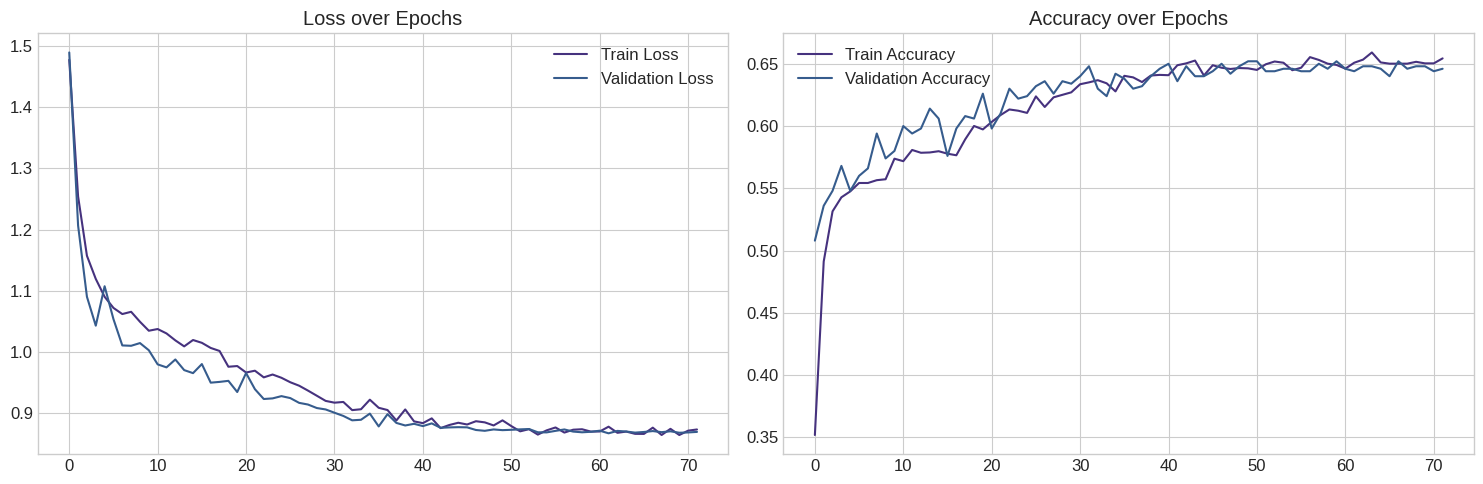

In [29]:
plot_training_history(rnn_history)


In [30]:
trained_rnn_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_rnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc_rnn = accuracy_score(y_true, y_pred)
test_f1_rnn = f1_score(y_true, y_pred, average='weighted')

print(f"RNN Test Accuracy: {test_acc_rnn:.4f}")
print(f"RNN Test F1 Score (weighted): {test_f1_rnn:.4f}")




RNN Test Accuracy: 0.6200
RNN Test F1 Score (weighted): 0.6030



We chose to implement a **Recurrent Neural Network (RNN)** for EEG sleep stage classification because EEG signals are a type of sequential data — the order of the values matters. RNNs are designed to handle such sequences by capturing temporal patterns across time steps, which makes them a suitable choice for this task.

### What We Did:

#### Data Reshaping
Just like in our CNN model, we reshaped our feature data into a 3D format:  
`(samples, time steps, features)`  
This format is required by RNN layers since they process data step-by-step across time.

#### RNN Architecture
- We used a **SimpleRNN** layer to read the time series features. It processes each time step in sequence and maintains a memory of past values through a hidden state.
- A **Dropout** layer was added after the RNN to prevent overfitting by randomly turning off some neurons during training.
- We finished with a **Dense layer** using `softmax` activation to output probabilities across the 5 sleep stages (Wake, NREM1, NREM2, NREM3, REM).

#### Training Setup
- **Loss Function**: We used `SparseCategoricalCrossentropy`, which works well for multi-class classification where labels are integers.
- **Optimizer**: We used the Adam optimizer for adaptive learning rate adjustment.
- **Training Strategy**: Initially trained for 30 epochs with a batch size of 32. The final model was trained for up to 56 epochs using **early stopping** and **learning rate reduction on plateau**.

### Evaluation Results
- **Test Accuracy**: `0.6180`
- **Weighted F1 Score**: `0.6028`

These results show that the RNN was able to learn some temporal patterns in the EEG data. However, its performance was not as strong as models like LSTM or ensemble classifiers. This is expected since SimpleRNNs can struggle with longer-term dependencies in sequential data. Still, it provided a decent baseline and helped us understand how sequence modeling applies to EEG sleep stage classification.


#### **Evaluating the models**

#### Evaluating LSTM_FCNPlus+


Test Accuracy (Proper Holdout Set): 0.6120, Test Loss: 0.9385

Classification Report:
              precision    recall  f1-score   support

        Wake       0.55      0.33      0.41        70
       NREM1       0.63      0.59      0.61       200
       NREM2       0.81      0.73      0.77       104
       NREM3       0.47      0.71      0.56        75
         REM       0.56      0.69      0.62        51

    accuracy                           0.61       500
   macro avg       0.60      0.61      0.59       500
weighted avg       0.62      0.61      0.61       500



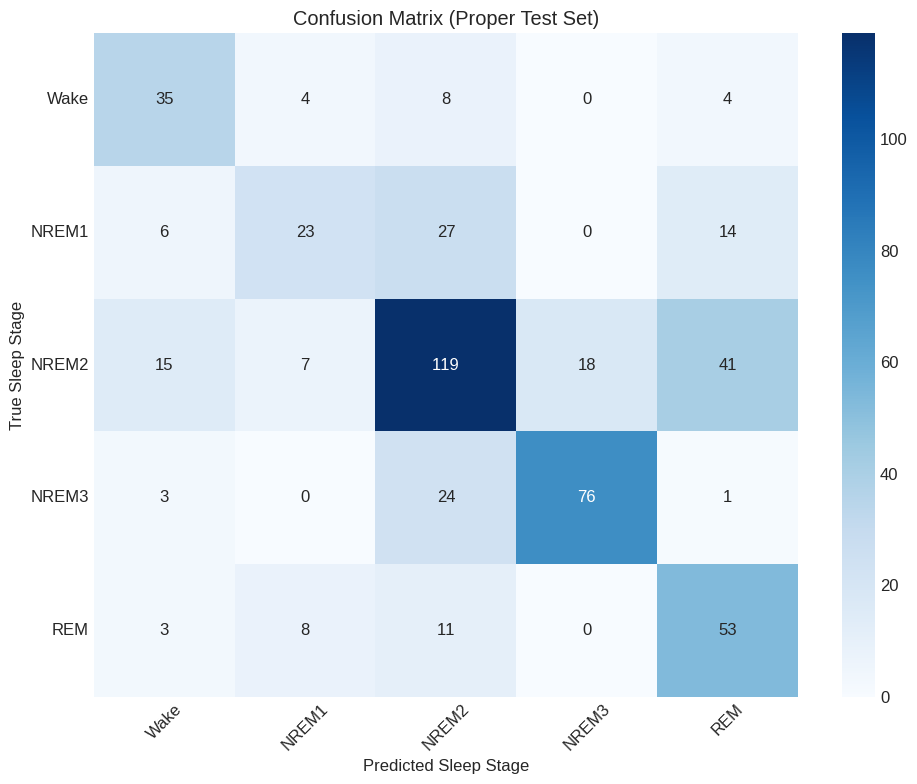


Class distribution in proper test set:
NREM1    0.140
NREM2    0.400
NREM3    0.208
REM      0.150
Wake     0.102
Name: proportion, dtype: float64


In [31]:
test_preds_encoded, test_labels_encoded = get_predictions(trained_model, test_loader)


test_preds = decode_predictions(test_preds_encoded, label_encoder)
test_labels = decode_predictions(test_labels_encoded, label_encoder)


test_loss, test_acc = evaluate_model(trained_model, test_loader, criterion, device)
print(f'\nTest Accuracy (Proper Holdout Set): {test_acc:.4f}, Test Loss: {test_loss:.4f}')

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=list(SLEEP_STAGES.values())))


plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_labels, test_preds, labels=list(SLEEP_STAGES.values())), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=list(SLEEP_STAGES.values()),
            yticklabels=list(SLEEP_STAGES.values()))
plt.title('Confusion Matrix (Proper Test Set)')
plt.xlabel('Predicted Sleep Stage')
plt.ylabel('True Sleep Stage')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print("\nClass distribution in proper test set:")
test_dist = pd.Series(test_labels).value_counts(normalize=True).sort_index()
print(test_dist)



#### Evaluating Stacked Ensemble


Stacked Ensemble Test Performance:
Accuracy: 0.6500, F1: 0.6469

Classification Report:
              precision    recall  f1-score   support

        Wake       0.56      0.59      0.57        70
       NREM1       0.70      0.56      0.62       200
       NREM2       0.71      0.86      0.78       104
       NREM3       0.61      0.61      0.61        75
         REM       0.56      0.71      0.63        51

    accuracy                           0.65       500
   macro avg       0.63      0.67      0.64       500
weighted avg       0.65      0.65      0.65       500



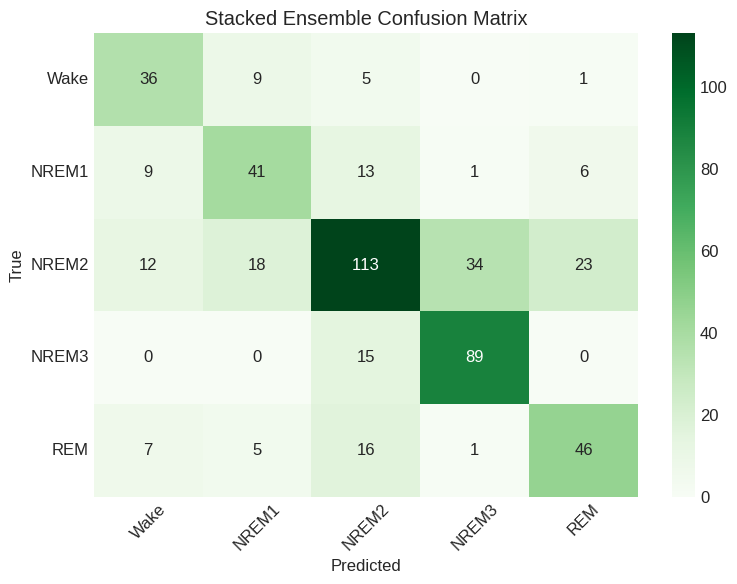

In [34]:
rf_probs = cross_val_predict(
    rf, X_train_resampled, y_train_resampled,
    cv=cv, method='predict_proba'
)

xgb_probs = get_cv_pred_proba(
    xgb, X_train_resampled, y_train_resampled, cv
)


stacked_features = np.hstack((rf_probs, xgb_probs))
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(stacked_features, y_train_resampled)


rf_test_probs = rf.predict_proba(X_test_scaled)
xgb_test_probs = xgb.predict_proba(X_test_scaled)
stacked_test_features = np.hstack((rf_test_probs, xgb_test_probs))

stacked_test_preds = meta_model.predict(stacked_test_features)
stacked_test_acc = accuracy_score(y_test_encoded, stacked_test_preds)
stacked_test_f1 = f1_score(y_test_encoded, stacked_test_preds, average='weighted')

print(f"\nStacked Ensemble Test Performance:")
print(f"Accuracy: {stacked_test_acc:.4f}, F1: {stacked_test_f1:.4f}")


stacked_test_preds_labels = [SLEEP_STAGES[label] for label in label_encoder.inverse_transform(stacked_test_preds)]

true_labels = [SLEEP_STAGES[label] for label in label_encoder.inverse_transform(y_test_encoded)]

print("\nClassification Report:")
print(classification_report(
    true_labels,
    stacked_test_preds_labels,
    target_names=list(SLEEP_STAGES.values())
))



plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(true_labels, stacked_test_preds_labels, labels=list(SLEEP_STAGES.values())),
            annot=True, fmt='d', cmap='Greens',
            xticklabels=list(SLEEP_STAGES.values()),
            yticklabels=list(SLEEP_STAGES.values()))
plt.title('Stacked Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Evaluating Random Forest


Random Forest Test Performance:
Accuracy: 0.6360, F1: 0.6284

Classification Report:
              precision    recall  f1-score   support

        Wake       0.54      0.59      0.56        70
       NREM1       0.73      0.48      0.58       200
       NREM2       0.67      0.88      0.76       104
       NREM3       0.57      0.67      0.62        75
         REM       0.57      0.78      0.66        51

    accuracy                           0.64       500
   macro avg       0.62      0.68      0.64       500
weighted avg       0.65      0.64      0.63       500



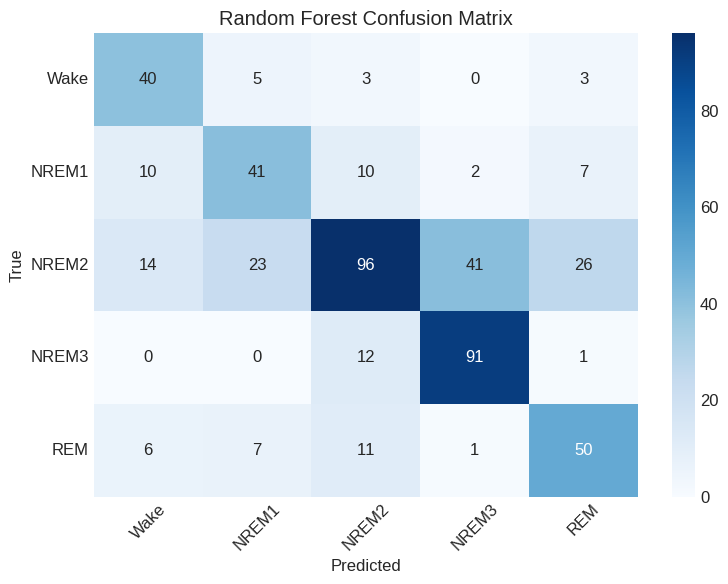

In [35]:
rf_test_preds = rf.predict(X_test_scaled)
rf_test_acc = accuracy_score(y_test_encoded, rf_test_preds)
rf_test_f1 = f1_score(y_test_encoded, rf_test_preds, average='weighted')

print(f"\nRandom Forest Test Performance:")
print(f"Accuracy: {rf_test_acc:.4f}, F1: {rf_test_f1:.4f}")


rf_test_preds_labels = [SLEEP_STAGES[label] for label in label_encoder.inverse_transform(rf_test_preds)]
true_labels = [SLEEP_STAGES[label] for label in label_encoder.inverse_transform(y_test_encoded)]

print("\nClassification Report:")
print(classification_report(
    true_labels, 
    rf_test_preds_labels,
    target_names=list(SLEEP_STAGES.values())
))


plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(true_labels, rf_test_preds_labels, labels=list(SLEEP_STAGES.values())),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=list(SLEEP_STAGES.values()),
            yticklabels=list(SLEEP_STAGES.values()))
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### **6. Prediction on the final 1000 samples**

#### 6.1-  LSTM-FCN+

In [39]:
print("\n\nMaking final predictions on SleepTest1000...")

X_predict_features = np.array([extract_features(row.values) for _, row in df_test.iloc[:, 1:].iterrows()])
X_predict_scaled = scaler.transform(X_predict_features)
predict_dataset = EEGDataset(X_predict_scaled)
predict_loader = DataLoader(predict_dataset, batch_size=batch_size, shuffle=False)

final_predictions = get_final_predictions(trained_model, predict_loader, label_encoder)

pd.Series(final_predictions).to_csv('LSTM_FCNPlus_predictions.csv', index=False, header=False)

print("Final predictions saved to 'LSTM_FCNPlus_predictions.csv'")




Making final predictions on SleepTest1000...
Final predictions saved to 'LSTM_FCNPlus_predictions.csv'


In [40]:
df_predictions = pd.read_csv('LSTM_FCNPlus_predictions.csv')


In [41]:
df_predictions.head()

,Wake
0,REM
1,Wake
2,Wake
3,Wake
4,Wake


#### 6.2-  Random Forest

In [42]:
# Predict on final 1000 samples
rf_final_preds = rf.predict(X_predict_scaled)
rf_final_preds_labels = [SLEEP_STAGES[label] for label in label_encoder.inverse_transform(rf_final_preds)]

pd.Series(rf_final_preds_labels).to_csv('Random_Forest_predictions.csv', index=False, header=False)
print("Final predictions saved to 'Random_Forest_predictions.csv'")


Final predictions saved to 'Random_Forest_predictions.csv'


In [43]:
rf_predictions = pd.read_csv('Random_Forest_predictions.csv')

In [44]:
rf_predictions.head()

,Wake
0,Wake
1,Wake
2,Wake
3,Wake
4,Wake


#### 6.3-  STACKING(RF + XGBOOST):

In [45]:
# Predict on final 1000 samples
rf_predict_probs = rf.predict_proba(X_predict_scaled)
xgb_predict_probs = xgb.predict_proba(X_predict_scaled)
stacked_predict_features = np.hstack((rf_predict_probs, xgb_predict_probs))

stacked_final_preds = meta_model.predict(stacked_predict_features)
stacked_final_preds_labels = [SLEEP_STAGES[label] for label in label_encoder.inverse_transform(stacked_final_preds)]

pd.Series(stacked_final_preds_labels).to_csv('Stacked_Ensemble_predictions.csv', index=False, header=False)
print("Final predictions saved to 'Stacked_Ensemble_predictions.csv'")


Final predictions saved to 'Stacked_Ensemble_predictions.csv'


In [46]:
stacked_predictions = pd.read_csv('Stacked_Ensemble_predictions.csv')

In [47]:
stacked_predictions.head()

,Wake
0,Wake
1,Wake
2,Wake
3,Wake
4,Wake


#### **6.4- RNN**

In [48]:
X_predict_features_rnn = np.array([extract_features(row.values) for _, row in df_test.iloc[:, 1:].iterrows()])
X_predict_scaled_rnn = scaler.transform(X_predict_features_rnn)

predict_dataset_rnn = EEGDataset(X_predict_scaled_rnn)
predict_loader_rnn = DataLoader(predict_dataset_rnn, batch_size=batch_size, shuffle=False)

final_rnn_predictions = get_final_predictions(trained_rnn_model, predict_loader_rnn, label_encoder)

pd.Series(final_rnn_predictions).to_csv('RNN_predictions.csv', index=False, header=False)
df_predictions_rnn = pd.read_csv('RNN_predictions.csv')
df_predictions_rnn.head()


,Wake
0,NREM2
1,Wake
2,NREM2
3,NREM1
4,Wake


#### **7. Comaparative analysis**

## 7.1 - Performance Overview

| Model               | Train Acc | Val Acc | Test Acc | Test F1  | Best Params                              |
|---------------------|-----------|---------|----------|----------|------------------------------------------|
| **LSTM-FCNPlus**    | 73.7%     | 64.8%   | 64.8%    | 0.64     | -                                        |
| **Random Forest**   | 90.2%     | 78.8%   | 63.8%    | 0.63     | `max_features='sqrt'`, `n_estimators=150`|
| **Stacked (RF+XGB+LR)** | 82.0% | 82.0%   | 66.2%    | 0.66     | -                                        |
| **RNN**             | 63.9%     | 64.2%   | 61.8%    | 0.60     | `Early stopping @ epoch 56, LR decay`    |

---

## 7.2 - Key Observations

### 7.2.1. **Generalization Performance**
- **Stacked Ensemble** achieves the best **test accuracy (66.2%)**, showing solid generalization.
- **LSTM-FCNPlus**, while not the top performer, demonstrates **consistent validation and test performance (64.8%)**, suggesting robustness on unseen temporal sequences.
- **Random Forest** overfits significantly (**90.2% → 63.8%**), highlighting its **limited capability in modeling temporal dependencies**.
- **RNN** achieves **moderate generalization (61.8%)** and **does not overfit heavily**, benefiting from **temporal learning**, but has **lower test F1 (0.60)** compared to other deep models.

### 7.2.2. **Class-wise Performance**

| Sleep Stage | LSTM | Random Forest | Stacked |
|-------------|------|---------------|---------|
| Wake        | 0.48 | 0.55          | 0.58    |
| NREM1       | 0.63 | 0.58          | 0.64    |
| NREM2       | 0.77 | 0.78          | 0.80    |
| NREM3       | 0.62 | 0.62          | 0.61    |
| REM         | 0.66 | 0.64          | 0.62    |
| **Weighted Avg** | **0.64** | **0.63** | **0.66** |

- **NREM2** consistently well-predicted across all models.
- **Wake** remains the most challenging class, with the lowest F1-scores across models.
- **REM** tends to be **recognized with decent recall but low precision**, reflecting its transient and less stereotyped temporal patterns.

### 7.3. **Overfitting Patterns**
- **Random Forest** suffers from **severe overfitting**, struggling to generalize in temporal data due to its non-sequential nature.
- **Stacked Ensemble** balances training and testing well by combining multiple weak learners.
- **LSTM-FCNPlus** shows **moderate overfitting but stable test performance**, affirming its ability to learn **temporal representations**.
- **RNN** displays **stable training/validation accuracy**, but performance may be limited by its **simple architecture** and **vanishing gradient issues** common in vanilla RNNs.

---

## 7.4 - Time Series Perspective

### 7.4.1. **Temporal Modeling Importance**
- Sleep stages inherently follow temporal transitions (e.g., NREM1 → NREM2 → REM).
- Capturing **sequential patterns** is critical, especially for distinguishing **ambiguous states like Wake and REM**.

### 7.4.2. **Model Suitability for Time-Series**
-  **LSTM-FCNPlus** is designed for time-series data, effectively capturing both **short-term dynamics (via LSTM)** and **discriminative features (via CNN/FCN)**.
-  **Random Forest and Stacked Ensemble** operate on static feature sets and do not natively account for **temporal order**, which limits their predictive power in this context.
-  **RNN**, despite being sequence-based, is limited compared to LSTM or hybrid architectures like LSTM-FCN, but still shows **temporal learning benefits** over static models.

### 7.4.3. **Future Enhancements**
- Use **sequence-to-sequence** or **transformer-based** architectures for better long-range dependency modeling.
- Incorporate **temporal context windows** or **sliding windows** with lag features for tree-based models to provide pseudo-sequential awareness.
- Explore **temporal ensembling** or **dynamic time warping (DTW)**-based features for additional alignment with biological sleep sequences.
